# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.

В рамках данного проекта в нашем распоряжении имеется 7591 изображений людей на фотографиях, а также файл с реальным возрастом людей, изображенных на каждом фото.

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/). 

Целевым признаком является `real_age`.
Задачей является предсказание возраста людей, изображенных на фото. Метрикой качества является MAE.

План работы:
- Провести исследовательский анализ данных
- Обучить модель 
- Проанализировать результаты обучения

## Исследовательский анализ данных

In [1]:
# импортируем библиотеки, которые понадобятся в работе
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# импортируем файл с исходными данными
data = pd.read_csv('/datasets/faces/labels.csv')
basic_datagen = ImageDataGenerator(rescale=1./255)
basic_gen_flow = basic_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Мы видим, что в выборке 7591 изображение.

In [3]:
# посмотрим на то, как выглядят первые несколько строк таблицы с данными
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# посмотрим на то, какого типа столбцы и нет ли пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# посмотрим на описательные статистики
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Мы видим, что средний возраст людей, изображенных на фото, составляет 31 год, при этом возраст самого молодого человека - 1 год, а возраст самого пожилого - 100 лет.

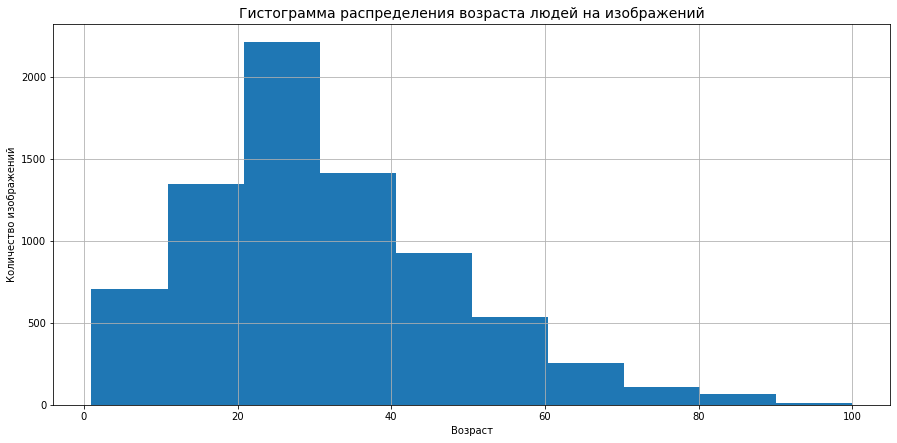

In [6]:
# посмотрим на распределение возраста людей, изображенных на фото
data['real_age'].hist(figsize=(15,7))
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Гистограмма распределения возраста людей на изображений', 
          size=14)
plt.show()

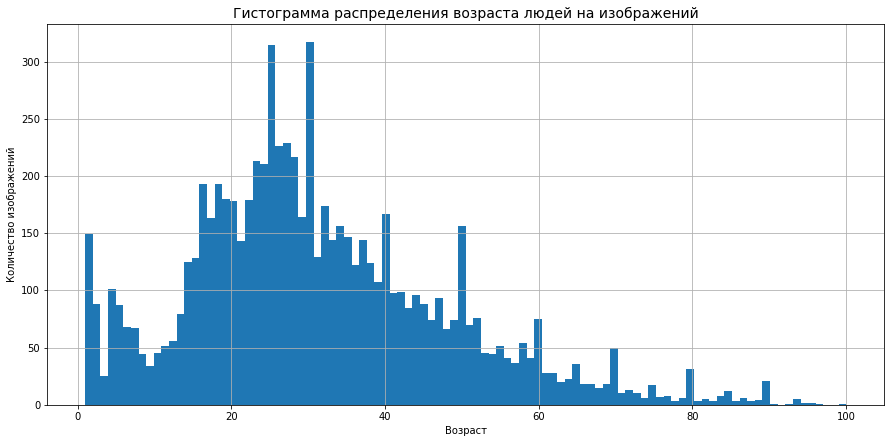

In [7]:
# теперь построим гистограмму с числом корзин = 100, 
# т.к. возраст всех людей на фото находится в диапазоне от 1 до 100 лет

data['real_age'].hist(figsize=(15,7), bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Гистограмма распределения возраста людей на изображений', 
          size=14)
plt.show()

Узнаем, что за 2 пика между 20 и 40 годами:

In [8]:
(
    data
    .pivot_table(index=['real_age'], aggfunc='count')
    .sort_values(by='file_name', ascending=False).head(2)
)

,file_name
real_age,
30,317
25,315


Наибольшее число изображений приходится на людей в возрасте 30 и 25 лет.

В целом, заметно, что больше "скачков" приходится на круглые возрасты типа 20, 25, 30, 40, 50, 60 лет, что, вероятно, свидетельствуют о том, что это примерный возраст, поскольку по информации из источника данных мы знаем, что возрасты формировались голосами.

In [9]:
# присвоим features и target
features, target = next(basic_gen_flow)

In [10]:
# посмотрим на размеры признаков
features.shape

(32, 224, 224, 3)

Изображения квадратные, имеют размер 224x224, с 3 цветовыми каналами (RGB).

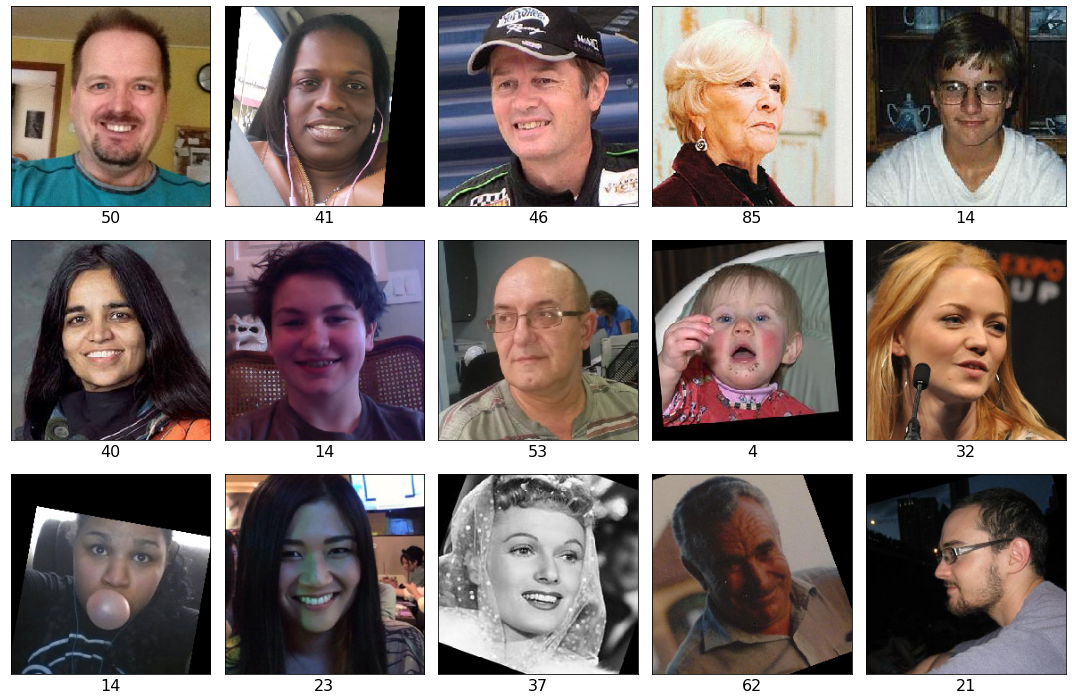

In [11]:
# выведем на экран несколько фотографий

photos = plt.figure(figsize=(15, 10))
for i in range(15):
    photos.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.xlabel(target[i], size=16)

Мы визуально убедились в том, что данные размечены корректно. Однако присутствуют различные шероховатости: повернутые фото, лицо может быть перекрыто.

**Вывод:**<br/>
Мы провели исследовательский анализ данных и пришли к следующим заключениям:
1. Размер выборки составляет 7591 изображение.
1. Посмотрев описательные характеристики, мы узнали, что средний возраст людей на фото - 31 год.
1. Посмотрев на гистограмму, мы узнали, что большая часть фото приходится на людей в возрасте (ориентировочно) от 15 до 40 лет. 
1. На более детальной гистограмме мы увидели, что есть наибольшее число изображений приходится на людей в возрасте 25 и 30 лет.
1. "Скачки" в детальной гистограмме свидетельствуют о том, что возраст многих людей определялся неточно, а на взгляд (голосами).
1. Исходные фото квадратные, размером 224x224, в цветовой палитре RGB.
1. Данные размечены корректно, однако присутствуют различные шероховатости.

## Обучение модели

```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

def load_train(path):
    data = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    data = pd.read_csv('/datasets/faces/labels.csv')
    valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return validation_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    steps_per_epoch = len(train_data)
    validation_steps = len(test_data)
    
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model
```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps

Epoch 1/5
190/190 - 49s - loss: 237.8177 - mae: 10.9195 - val_loss: 883.3386 - val_mae: 24.7185

Epoch 2/5
190/190 - 40s - loss: 78.7789 - mae: 6.7019 - val_loss: 757.3028 - val_mae: 22.4252

Epoch 3/5
190/190 - 40s - loss: 51.8207 - mae: 5.5168 - val_loss: 230.8359 - val_mae: 11.3331

Epoch 4/5
190/190 - 40s - loss: 35.8959 - mae: 4.5801 - val_loss: 100.0250 - val_mae: 7.5812

Epoch 5/5
190/190 - 40s - loss: 28.6951 - mae: 4.0728 - val_loss: 76.6015 - val_mae: 6.6765

48/48 - 8s - loss: 76.6015 - mae: 6.6765
Test MAE: 6.6765

## Анализ обученной модели

1. Test MAE: 6.6765, при цели в "не больше 8". Задача выполнена. Более того, значение даже менее 7, что можно считать "отличным результатом". Как и было предложено, использовалась архитектура ResNet50, был взять learning rate, равный 0.0001.
1. Что касается сформулированных задач, модель вполне способна анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, однако контролировать добросовестность кассиров при продаже алкоголя может быть затруднительно, риск ошибки все же велик. Данную задачу пока что не стоит поручать нейронным сетям.

## Вывод

Мы провели исследовательский анализ данных и пришли к следующим заключениям:
1. Размер выборки составляет 7591 изображение.
1. Посмотрев описательные характеристики, мы узнали, что средний возраст людей на фото - 31 год.
1. Посмотрев на гистограмму, мы узнали, что большая часть фото приходится на людей в возрасте (ориентировочно) от 15 до 40 лет. 
1. На более детальной гистограмме мы увидели, что есть наибольшее число изображений приходится на людей в возрасте 25 и 30 лет.
1. "Скачки" в детальной гистограмме свидетельствуют о том, что возраст многих людей определялся неточно, а на взгляд (голосами).
1. Исходные фото квадратные, размером 224x224, в цветовой палитре RGB.
1. Данные размечены корректно, однако присутствуют различные шероховатости.

Затем мы построили модель, проанализировали ее и пришли к следующим выводам:
1. Test MAE: 6.6765, при цели в "не больше 8". Задача выполнена. Более того, значение даже менее 7, что можно считать "отличным результатом". Как и было предложено, использовалась архитектура ResNet50, был взять learning rate, равный 0.0001.
1. Что касается сформулированных задач, модель вполне способна анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, однако контролировать добросовестность кассиров при продаже алкоголя может быть затруднительно, риск ошибки все же велик. Данную задачу пока что не стоит поручать нейронным сетям.

Возможно, есть смысл расширить и уравновесить исходный набор данных, для более точного прогнозирования.